In [2]:
import glob
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from tensorflow import keras

from sklearn.model_selection import train_test_split

In [3]:
instrument_Names = ['guitar','sexophone']

In [4]:
train = []
target = []

In [5]:
for name in instrument_Names:
    for image in sorted(glob.glob('../../Data/%sresize/*.jpg'%name)):
        img = Image.open(image)
        img = img.convert('L')
        train.append(img)
        target.append(name)

# train,test 만들기

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    train, target, test_size=0.2
)

In [8]:
trainData = np.zeros(len(x_train) * 100*100, dtype=np.int32).reshape(len(x_train), 100, 100)
testData = np.zeros(len(x_test) * 100*100, dtype=np.int32).reshape(len(x_test), 100, 100)

In [9]:
i = 0
for image in x_train:
    img = np.array(image, dtype=np.int32)
    trainData[i,:,:] = img
    i += 1

i = 0
for image in x_test:
    img = np.array(image, dtype=np.int32)
    testData[i,:,:] = img
    i += 1

In [10]:
print(trainData.shape)
print(testData.shape)

(24, 100, 100)
(6, 100, 100)


In [11]:
#data의 정규화
trainData=trainData.astype('float32')/255
testData=testData.astype('float32')/255

trainData=trainData.reshape((len(trainData),100*100))
testData=testData.reshape((len(testData),100*100))

In [12]:
print(trainData.shape)
print(testData.shape)

(24, 10000)
(6, 10000)


### Tensorflow Model 만들기

### Dense 수치와 epochs 수치만 조절하면된다. 
### shape가 100*100 이므로 Dense값도 어느정도 크게 입력을 해주는 것이 좋다.(100*100보다 작을 필요는 없다)
### 데이터가 적으면 epochs를 늘려서 학습을 더 시켜줘야한다.

In [13]:
# MNIST Data를 입력으로
InputModel=keras.layers.Input(shape=(100*100))

#EncoderLayer는 3차원으로 축소된 입력값
noiseInput = keras.layers.GaussianNoise(stddev=0.2)(InputModel)
EncodedLayer=keras.layers.Dense(5000,activation='relu')(noiseInput) 
#EncodedLayer =keras.layers.Dropout(0.1)(EncodedLayer) 
EncodedLayer=keras.layers.Dense(2500,activation='relu')(EncodedLayer)
#EncodedLayer =keras.layers.Dropout(0.1)(EncodedLayer)
EncodedLayer=keras.layers.Dense(1250,activation='relu')(EncodedLayer)
#EncodedLayer =keras.layers.Dropout(0.1)(EncodedLayer)
EncodedLayer=keras.layers.Dense(625,activation='relu')(EncodedLayer)
#EncodedLayer =keras.layers.Dropout(0.1)(EncodedLayer)

#latent view
EncodedLayer=keras.layers.Dense(100,activation='relu')(EncodedLayer)



# 디코더 모델 정의
DecoderLayer = keras.layers.Dense(625, activation='relu')(EncodedLayer)
DecoderLayer = keras.layers.Dense(1250, activation='relu')(DecoderLayer)
DecoderLayer = keras.layers.Dense(2500, activation='relu')(DecoderLayer)
DecoderLayer = keras.layers.Dense(5000, activation='relu')(DecoderLayer)

# DecoderLayer는 MNIST 차원으로 복원된 값
DecoderLayer=keras.layers.Dense(100*100,activation='sigmoid')(DecoderLayer)

# AutoEncoderModel은 입력값과 복원값을 최소화 하는 과정
AutoencoderModel=keras.models.Model(InputModel,DecoderLayer)

In [14]:
AutoencoderModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 10000)            0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 5000)              50005000  
                                                                 
 dense_1 (Dense)             (None, 2500)              12502500  
                                                                 
 dense_2 (Dense)             (None, 1250)              3126250   
                                                                 
 dense_3 (Dense)             (None, 625)               781875    
                                                             

In [15]:
AutoencoderModel.compile(optimizer='adam',loss='binary_crossentropy')

In [16]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

history=AutoencoderModel.fit(trainData,trainData,
                             batch_size=128, # 한번에 읽어들이는 데이터의 양. 작업 속도만 차이가 날 뿐 결과물은 차이가 없다.
                             epochs=1000,
                             shuffle=True,
                             validation_data=(testData,testData),
                             )

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 0.6931 - val_loss: 0.5960
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5943 - val_loss: 6.7418
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 6.2321 - val_loss: 0.5466
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5416 - val_loss: 0.6862
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6858 - val_loss: 0.6927
Epoch 6/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6921 - val_loss: 0.6843
Epoch 7/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6837 - val_loss: 0.6310
Epoch 8/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6302 - val_loss: 0.4626
Epoch 9/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4591 - val_loss: 0.7619
Epoch 10/1000
1/1 [==============================] - 1s 1s/step - loss: 0.7130 - val_loss: 0.4039
Epoch 11/1000
1/1 [==========

KeyboardInterrupt: 

In [101]:
DecodedDigits=AutoencoderModel.predict(testData)

1/1 [==============================] - 0s 78ms/step


In [102]:
# testData와 DecodedDigits의 크기
print(testData.shape)
print(DecodedDigits.shape)

(8, 10000)
(8, 10000)


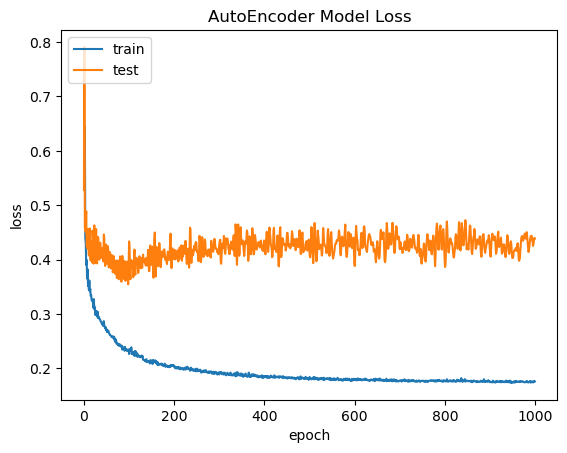

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('AutoEncoder Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')

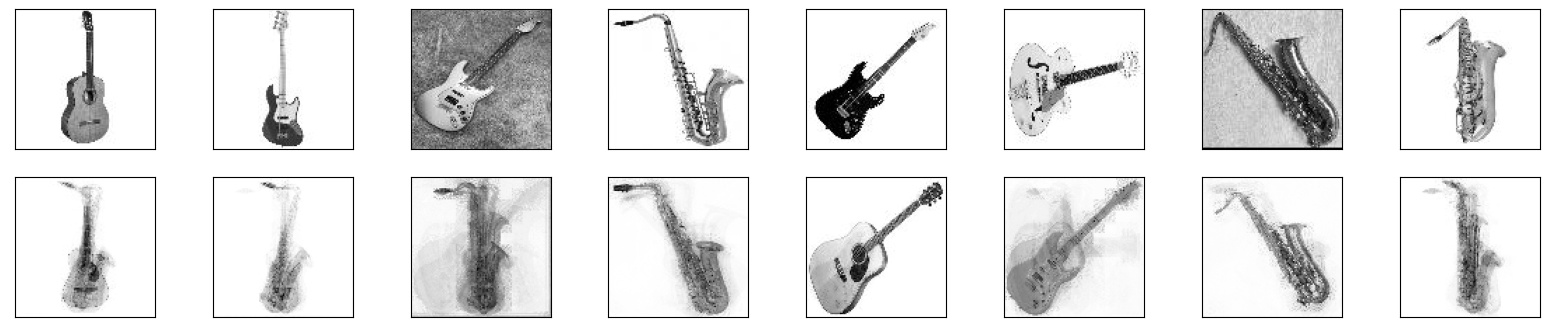

In [104]:
# test data 시각화
n=3
plt.figure(figsize=(20,4))
for i in range(n):
    ax=plt.subplot(2,n,i+1)
    plt.imshow(testData[i].reshape(100,100))
    ax.get_xaxis().set_visible(False)#축 안보여주겠다.
    ax.get_yaxis().set_visible(False)#축 안보여주겠다.
    plt.gray()
    #-----------------
    ax=plt.subplot(2,n,i+1+n)
    plt.imshow(DecodedDigits[i].reshape(100,100))
    ax.get_xaxis().set_visible(False)#축 안보여주겠다.
    ax.get_yaxis().set_visible(False)#축 안보여주겠다.
    plt.gray()
plt.show()#위에가 원본 데이터 밑에가 압축되어 나온 데이터이다. data size가 줄어든 것을 확인할 수 있다.